<a href="https://colab.research.google.com/github/ZenithSun/Presentations/blob/main/Truth_Social_Posts_Analysis_for_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Package Preparation

In [ ]:
!pip install --upgrade openai requests pandas matplotlib polygon-api-client mplfinance pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import time
import random
import json
from dateutil import parser as date_parser
import os
import re
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm

In [ ]:
from polygon.rest import RESTClient
import statsmodels.api as sm
import pandas_market_calendars as mcal


# Step 1: Fetch Trump Truth Social Posts Data

## Method 1: Web Scrape the Truth Social Posts from Trump (First Time Data Loading)

In [ ]:

WEBSCRPER_API_KEY = "REPLACE WITH YOUR API KEY"
USER_ID = "107780257626128497"
BASE_URL = "https://api.scrapecreators.com/v1/truthsocial/user/posts"
SECOND_TERM_START = date_parser.parse("2025-01-20T00:00:00Z")
SAVE_PATH = "/content/drive/MyDrive/Speech & Sharing/posts.json"

headers = {
    "x-api-key": WEBSCRPER_API_KEY
}

max_id = None
retry_count = 0
MAX_RETRIES = 3
all_posts = []

while True:
    url = f"{BASE_URL}?user_id={USER_ID}"
    if max_id:
        url += f"&next_max_id={max_id}"

    print(f"\n🔁 Requesting posts with max_id: {max_id}")
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"❌ Failed with status {response.status_code}")
        break

    data = response.json()
    posts = data.get("posts", [])
    if not posts:
        print("✅ No more posts.")
        break

    print(f"📦 Retrieved {len(posts)} posts")

    all_posts.extend(posts)

    # Save to file after each batch
    os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
    with open(SAVE_PATH, "w", encoding="utf-8") as f:
        json.dump(all_posts, f, ensure_ascii=False, indent=2)
    print(f"💾 Saved {len(all_posts)} posts to: {SAVE_PATH}")

    last_post = posts[-1]
    created_at = date_parser.parse(last_post["created_at"])
    print(f"📅 Last post date: {created_at.isoformat()}")

    if created_at < SECOND_TERM_START:
        print("🛑 Post is before second term. Stopping.")
        break

    new_max_id = data.get("next_max_id")
    if new_max_id == max_id:
        retry_count += 1
        print(f"⚠️ Same max_id detected (retry {retry_count}/{MAX_RETRIES}). Sleeping and retrying...")
        time.sleep(random.uniform(15, 25))
        if retry_count >= MAX_RETRIES:
            print("❌ Max retries reached. Exiting.")
            break
    else:
        retry_count = 0
        max_id = new_max_id
        time.sleep(random.uniform(7, 12))


🔁 Requesting posts with max_id: None
📦 Retrieved 20 posts
💾 Saved 20 posts to: /content/drive/MyDrive/Speech & Sharing/posts.json
📅 Last post date: 2025-05-26T10:22:12.280000+00:00

🔁 Requesting posts with max_id: 114573635241995384
📦 Retrieved 20 posts
💾 Saved 40 posts to: /content/drive/MyDrive/Speech & Sharing/posts.json
📅 Last post date: 2025-05-23T22:11:23.443000+00:00

🔁 Requesting posts with max_id: 114559436943598657
📦 Retrieved 20 posts
💾 Saved 60 posts to: /content/drive/MyDrive/Speech & Sharing/posts.json
📅 Last post date: 2025-05-22T04:11:44.036000+00:00

🔁 Requesting posts with max_id: 114549529250052858
📦 Retrieved 20 posts
💾 Saved 80 posts to: /content/drive/MyDrive/Speech & Sharing/posts.json
📅 Last post date: 2025-05-19T21:40:46.708000+00:00

🔁 Requesting posts with max_id: 114536667329883384
📦 Retrieved 20 posts
💾 Saved 100 posts to: /content/drive/MyDrive/Speech & Sharing/posts.json
📅 Last post date: 2025-05-18T11:11:33.016000+00:00

🔁 Requesting posts with max_id: 

## Method 2: Load the Trump Posts Checkpoint

In [ ]:
# Load posts
with open("/content/drive/MyDrive/Speech & Sharing/posts.json", "r", encoding="utf-8") as f:
    raw_posts = json.load(f)

# Filter only text posts
text_posts = []
for post in raw_posts:
    content = re.sub(r'<[^>]+>', '', post.get("content", "")).strip()
    if content:
        text_posts.append({
            "created_at": post["created_at"],
            "text": content
        })

# Create DataFrame
df = pd.DataFrame(text_posts)
df["created_at"] = pd.to_datetime(df["created_at"])
# df["text_clean"] = df["text"].str.lower().str.replace(r'[^a-z\s]', '', regex=True)

df.shape, len(raw_posts)

((1770, 2), 2220)

In [ ]:
df.head()

,created_at,text
0,2025-05-26 19:19:56.623000+00:00,"Sheriff Scott Jenkins, his wife Patricia, and ..."
1,2025-05-26 15:21:32.503000+00:00,https://rumble.com/v6tw481-president-trump-par...
2,2025-05-26 13:06:18.994000+00:00,I will be making a Memorial Day Speech today a...
3,2025-05-26 12:42:04.085000+00:00,We are still waiting for the Foreign Student L...
4,2025-05-26 12:27:07.025000+00:00,I am considering taking Three Billion Dollars ...


#  Step 2: Use ChaGPT 4 for Topic Modeling and Sentiment Analysis

## Method 1: Call OpenAI API (First Time Data Loading)

In [ ]:
import openai
OPENAI_API_KEY = "REPLACE WITH YOUR API KEY"
client = openai.OpenAI(api_key=OPENAI_API_KEY)


In [ ]:
openai_results = {}
# Define the prompt function
def analyze_post(client, text):
    prompt = f"""
You are a financial NLP expert. Analyze the following post.

Post:
{text}

Extract:
1. Main topics (max 3, finance/economy-focused)
2. Sentiment (positive, negative, or neutral)
3. Confidence (0-1)

Respond ONLY in this JSON format:
{{
  "main_topics": [...],
  "sentiment": "...",
  "confidence": ...
}}
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2
        )
        content = response.choices[0].message.content
        result = json.loads(content)

        return result.get("main_topics"), result.get("sentiment"), result.get("confidence")
    except Exception as e:
        print(f"⚠️ Error: {e}")
        return None, None, None

# Loop through posts (limit for demo purposes if needed)
topics = []
sentiments = []
confidences = []


for i, row in df.iterrows():
    print(f"🔍 Analyzing post {i+1}/{len(df)}")
    if row["text"] in openai_results:
        print("✅ Already analyzed. Skipping...")
        topics.append(openai_results[row["text"]]["main_topics"])
        sentiments.append(openai_results[row["text"]]["sentiment"])
        confidences.append(openai_results[row["text"]]["confidence"])
        continue
    else:
      t, s, c = analyze_post(client, row["text"])
      topics.append(t)
      sentiments.append(s)
      confidences.append(c)
      openai_results[row["text"]] = {"main_topics": t, "sentiment": s, "confidence": c}
      with open("/content/drive/MyDrive/Speech & Sharing/openai_results.json", "w", encoding="utf-8") as f:
        json.dump(openai_results, f, ensure_ascii=False, indent=2)
    time.sleep(1.5)  # respect API rate limits

# Add results to DataFrame
df["main_topics"] = topics
df["sentiment_llm"] = sentiments
df["confidence"] = confidences

🔍 Analyzing post 1/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 2/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 3/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 4/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 5/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 6/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 7/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 8/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 9/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 10/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 11/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 12/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 13/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 14/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 15/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 16/1770
✅ Already analyzed. Skipping...
🔍 Analyzing post 17/1770
🔍 Analyzing post 18/1770
🔍 Analyzing post 19/1770
🔍 Analyzing post 20/17

## Method 2: Load the Checkpoint of Topics and Sentiments

In [ ]:
with open("/content/drive/MyDrive/Speech & Sharing/openai_results.json", "r", encoding="utf-8") as f:
    openai_results = json.load(f)

# Step 3. Data Analysis

In [ ]:
# 1. Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(openai_results, orient='index').reset_index()
results_df.columns = ['text', 'main_topics', 'sentiment_llm', 'confidence']

# 2. Make sure 'text' column in both DataFrames is consistent type
df['text'] = df['text'].astype(str)
results_df['text'] = results_df['text'].astype(str)

# 3. Perform left join
df_combined = df.merge(results_df, on='text', how='left')
df_combined['created_at'] = pd.to_datetime(df_combined['created_at'])

In [ ]:
df_combined.head()

,created_at,text,main_topics,sentiment_llm,confidence
0,2025-05-26 19:19:56.623000+00:00,"Sheriff Scott Jenkins, his wife Patricia, and ...",[],negative,0.95
1,2025-05-26 15:21:32.503000+00:00,https://rumble.com/v6tw481-president-trump-par...,[],neutral,1.00
2,2025-05-26 13:06:18.994000+00:00,I will be making a Memorial Day Speech today a...,[],neutral,1.00
3,2025-05-26 12:42:04.085000+00:00,We are still waiting for the Foreign Student L...,"[government spending, foreign student admissio...",negative,0.92
4,2025-05-26 12:27:07.025000+00:00,I am considering taking Three Billion Dollars ...,"[grant allocation, education funding, trade sc...",positive,0.95


In [ ]:
POLYGON_API_KEY = "REPLACE WITH YOUR API KEY"

polygon_client = RESTClient(api_key=POLYGON_API_KEY)

In [ ]:
# Function to get minute-level aggregate data
def get_aggregate_data(symbol, event_datetime, window_minutes=30):
    start_datetime = event_datetime - timedelta(minutes=window_minutes)
    end_datetime = event_datetime + timedelta(minutes=window_minutes)

    bars = polygon_client.get_aggs(
        ticker=symbol,
        multiplier=1,
        timespan='minute',
        from_=start_datetime.strftime('%Y-%m-%d'),
        to=end_datetime.strftime('%Y-%m-%d')
    )

    bars_df = pd.DataFrame(bars)

    if bars_df.empty:
        return pd.DataFrame()

    bars_df['timestamp'] = pd.to_datetime(bars_df['timestamp'], unit='ms', utc=True)

    # Ensure event_datetime is also timezone-aware in UTC
    start_datetime = start_datetime.tz_convert('UTC')
    end_datetime = end_datetime.tz_convert('UTC')

    bars_df = bars_df[
        (bars_df['timestamp'] >= start_datetime) &
        (bars_df['timestamp'] <= end_datetime)
    ]

    bars_df.set_index('timestamp', inplace=True)

    return bars_df


# Check market open hours
def is_market_open(dt):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=dt.date(), end_date=dt.date())
    if schedule.empty:
        return False
    market_open = schedule.iloc[0]['market_open']
    market_close = schedule.iloc[0]['market_close']
    return market_open <= dt <= market_close

# Apply function on df_combined and store stock data
def enrich_df_with_stock_data(df, symbol):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['data_pulled'] = False
    df['stock_data'] = None

    for idx, row in df.iterrows():
        event_datetime = row['created_at']
        if row['main_topics'] and is_market_open(event_datetime):
            print(f" Pulling stock data for {event_datetime}")
            stock_data = get_aggregate_data(symbol, event_datetime)
            if not stock_data.empty:
                df.at[idx, 'data_pulled'] = True
                df.at[idx, 'stock_data'] = stock_data

    return df


## 3.1 Event Driven Price Movement


### Example: SPY price movement triggered by Trump Posts

In [ ]:
df_combined_enriched = enrich_df_with_stock_data(df_combined, 'SPY')
df_combined_enriched['created_at'] = pd.to_datetime(df_combined['created_at'])
df_combined_enriched.head()

 Pulling stock data for 2025-05-23 19:37:11.074000+00:00
 Pulling stock data for 2025-05-23 19:25:17.732000+00:00
 Pulling stock data for 2025-05-22 18:28:52.090000+00:00
 Pulling stock data for 2025-05-22 17:33:35.465000+00:00
 Pulling stock data for 2025-05-20 19:55:51.820000+00:00
 Pulling stock data for 2025-05-20 19:55:31.398000+00:00
 Pulling stock data for 2025-05-19 17:33:06.392000+00:00
 Pulling stock data for 2025-05-16 19:27:16.669000+00:00
 Pulling stock data for 2025-05-16 15:02:50.209000+00:00
 Pulling stock data for 2025-05-16 14:07:23.987000+00:00
 Pulling stock data for 2025-05-14 17:43:04.844000+00:00
 Pulling stock data for 2025-05-14 15:17:11.989000+00:00
 Pulling stock data for 2025-05-13 17:43:22.547000+00:00
 Pulling stock data for 2025-05-12 19:12:43.782000+00:00
 Pulling stock data for 2025-05-12 19:12:29.541000+00:00
 Pulling stock data for 2025-05-12 19:12:16.971000+00:00
 Pulling stock data for 2025-05-12 17:55:32.464000+00:00
 Pulling stock data for 2025-05

,created_at,text,main_topics,sentiment_llm,confidence,data_pulled,stock_data
0,2025-05-26 19:19:56.623000+00:00,"Sheriff Scott Jenkins, his wife Patricia, and ...",[],negative,0.95,False,None
1,2025-05-26 15:21:32.503000+00:00,https://rumble.com/v6tw481-president-trump-par...,[],neutral,1.00,False,None
2,2025-05-26 13:06:18.994000+00:00,I will be making a Memorial Day Speech today a...,[],neutral,1.00,False,None
3,2025-05-26 12:42:04.085000+00:00,We are still waiting for the Foreign Student L...,"[government spending, foreign student admissio...",negative,0.92,False,None
4,2025-05-26 12:27:07.025000+00:00,I am considering taking Three Billion Dollars ...,"[grant allocation, education funding, trade sc...",positive,0.95,False,None


In [ ]:
df_combined_enriched.query('data_pulled == True').shape

(305, 7)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import mplfinance as mpf
from datetime import timedelta
import pytz

In [ ]:
# Function to plot SPY candlestick with Bloomberg-like style and text annotation
def plot_spy_event_candlestick(event_time):
    spy_data = get_aggregate_data('SPY', event_time)
    if spy_data.empty:
        print("No data available for the given time.")
        return

    spy_data.index = spy_data.index.tz_convert('America/New_York')
    event_time_est = event_time.astimezone(pytz.timezone('America/New_York'))

    mpf.plot(
        spy_data,
        type='candle',
        volume=True,
        style='mike',
        title=f'SPY Candlestick Price Movement Around Event ({event_time_est.strftime("%Y-%m-%d %H:%M %Z")})',
        ylabel='Price ($)',
        ylabel_lower='Volume',
        vlines=dict(
            vlines=[event_time_est],
            colors='red',
            linewidths=2.0,
            linestyle='--',
            alpha=0.8
        ),
        datetime_format='%Y-%m-%d %H:%M',
        xrotation=45,
        figratio=(18, 6)
    )


Post: THIS IS A GREAT TIME TO BUY!!! DJT
-------------


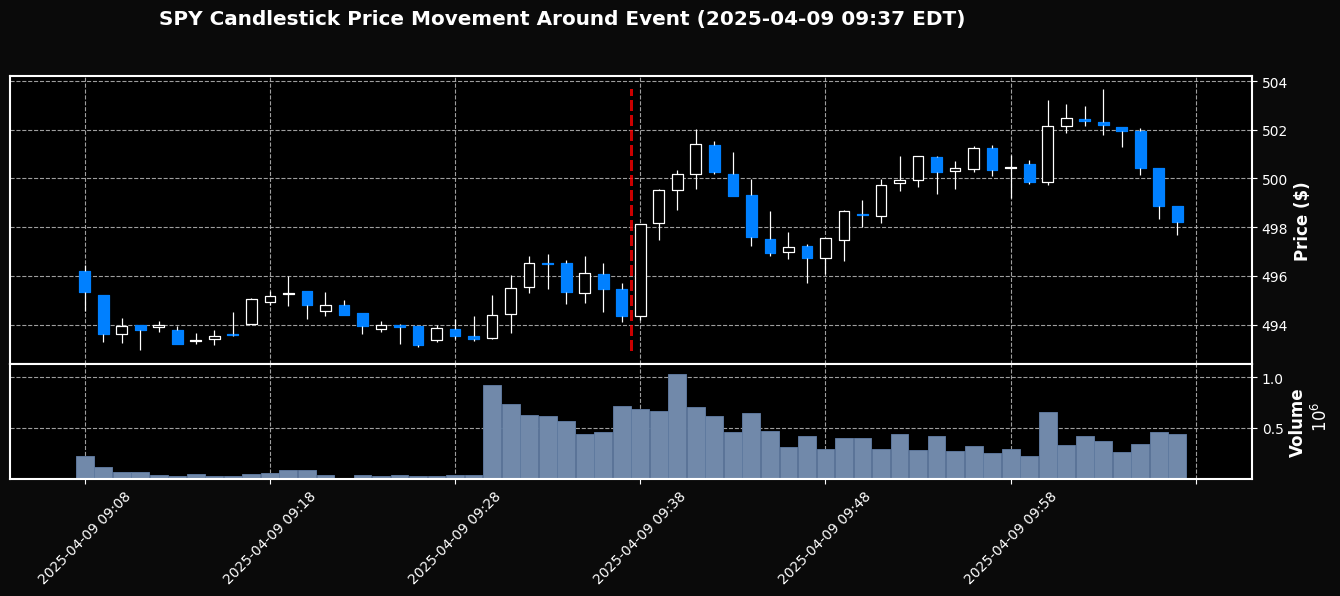

In [ ]:
###### Case 1 ###########
# Define the event timestamp
event_time = pd.Timestamp('2025-04-09 13:37:01.627000+00:00')
print("Post: {}".format(df_combined_enriched[df_combined_enriched.created_at==event_time].text.to_list()[0]))
print('-------------')
plot_spy_event_candlestick(event_time)
# (502 / 495 -1 = 1.4% growth within about 4 minutes)

Post: Based on the lack of respect that China has shown to the World’s Markets, I am hereby raising the Tariff charged to China by the United States of America to 125%, effective immediately. At some point, hopefully in the near future, China will realize that the days of ripping off the U.S.A., and other Countries, is no longer sustainable or acceptable. Conversely, and based on the fact that more than 75 Countries have called Representatives of the United States, including the Departments of Commerce, Treasury, and the USTR, to negotiate a solution to the subjects being discussed relative to Trade, Trade Barriers, Tariffs, Currency Manipulation, and Non Monetary Tariffs, and that these Countries have not, at my strong suggestion, retaliated in any way, shape, or form against the United States, I have authorized a 90 day PAUSE, and a substantially lowered Reciprocal Tariff during this period, of 10%, also effective immediately. Thank you for your attention to this matter!
------------

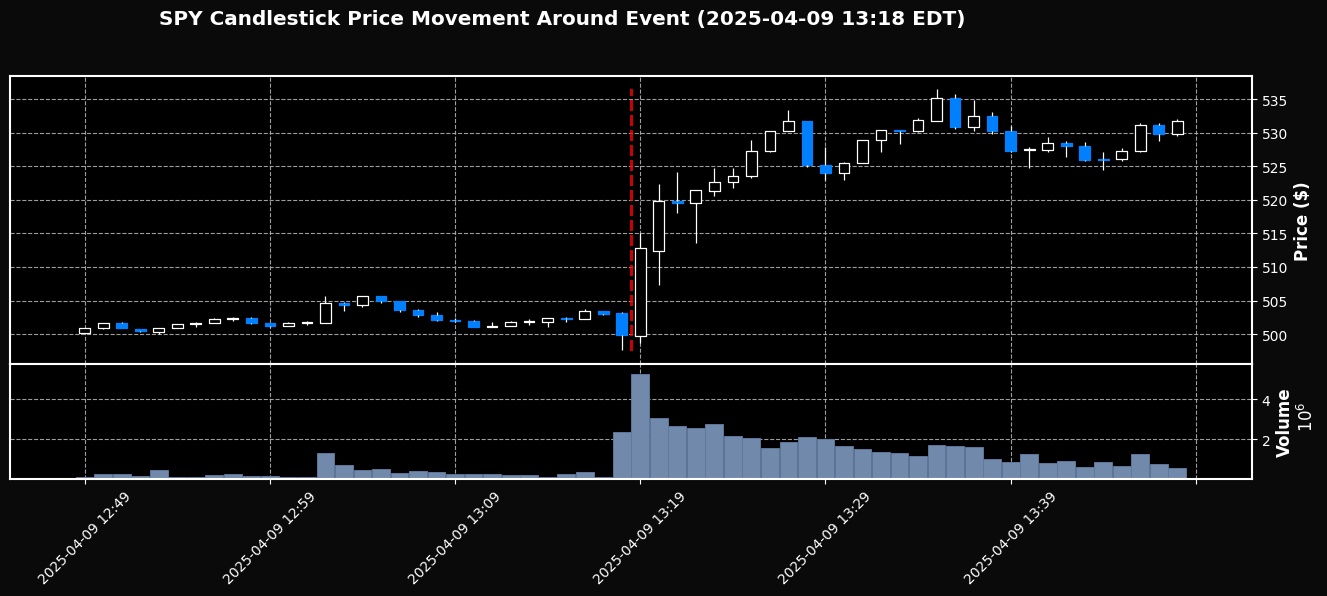

In [ ]:
###### Case 2 ###########
# Example usage
event_time = pd.Timestamp('2025-04-09 17:18:40.629000+00:00')
print("Post: {}".format(df_combined_enriched[df_combined_enriched.created_at==event_time].text.to_list()[0]))
print('-------------')
plot_spy_event_candlestick(event_time)
# (530 / 503 -1 = 5.4% grwoth within 10 minutes)

In [ ]:
# specific_date = pd.Timestamp('2025-04-07').date()
# df_combined_enriched[(df_combined_enriched.created_at.dt.date==specific_date) & (df_combined_enriched.data_pulled==True)]

## 3.2 Social Media Post and Maintream Media Breaking News

### Time Gaps between Social Media Post and Maintream Media Breaking News

In [ ]:
trump_post_time = pd.Timestamp('2025-04-09 13:37:01.627000+00:00').tz_convert('America/New_York')
trump_post_time
# 2025-04-09 09:37 AM EDT

######## BLOOMBERG #################
# https://www.bloomberg.com/news/videos/2025-04-09/trump-says-be-cool-as-stocks-hit-by-trade-war-video?utm_source=chatgpt.com
# 2025-04-09 12:48 PM EDT


####### WSJ ######################
# Can't find the earliest report time

Timestamp('2025-04-09 09:37:01.627000-0400', tz='America/New_York')

In [ ]:
trump_post_time = pd.Timestamp('2025-04-09 17:18:40.629000+00:00').tz_convert('America/New_York')
trump_post_time
# 2025-04-09 1:18 PM EDT

######## BLOOMBERG #################
# https://www.bloomberg.com/news/articles/2025-04-09/trump-pauses-higher-duties-on-most-nations-hikes-china-tariffs?utm_source=chatgpt.com
# 2025-04-09 1:25 PM EDT

####### WSJ ######################
# Can't find the earliest report time

spy_data = get_aggregate_data('SPY', trump_post_time)

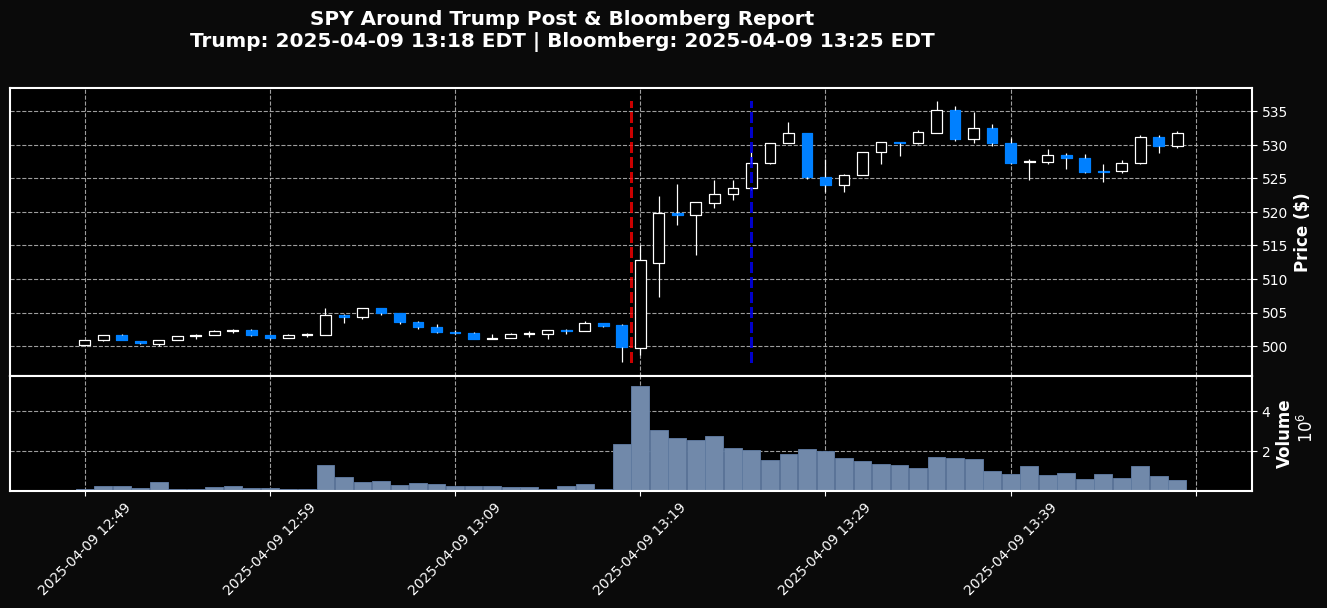

In [ ]:
# Convert DataFrame index to US Eastern time
spy_data.index = spy_data.index.tz_convert('America/New_York')

# Define UTC timestamp for Trump post
trump_post_utc = datetime.fromisoformat("2025-04-09T17:18:40.629000+00:00")
# Convert to Eastern time
eastern = pytz.timezone('America/New_York')
trump_post_est = trump_post_utc.astimezone(eastern)

# Define Bloomberg report time correctly in Eastern time
bloomberg_report_est = eastern.localize(datetime(2025, 4, 9, 13, 25, 0))

# Plot with vertical lines
vlines = dict(
    vlines=[trump_post_est, bloomberg_report_est],
    colors=['red', 'blue'],
    linewidths=[2.0, 2.0],
    linestyle='--',
    alpha=0.8
)

mpf.plot(
    spy_data,
    type='candle',
    volume=True,
    style='mike',
    title=(
        f'SPY Around Trump Post & Bloomberg Report\n'
        f'Trump: {trump_post_est.strftime("%Y-%m-%d %H:%M %Z")} | '
        f'Bloomberg: {bloomberg_report_est.strftime("%Y-%m-%d %H:%M %Z")}'
    ),
    ylabel='Price ($)',
    ylabel_lower='Volume',
    vlines=vlines,
    datetime_format='%Y-%m-%d %H:%M',
    xrotation=45,
    figratio=(18, 6)
)

## 3.3 The Complexity of Finding "Signals"

In [ ]:
market_open_df = df_combined_enriched.query('data_pulled == True').copy()
market_open_df.shape

(305, 7)

In [ ]:
market_open_df.head()

,created_at,text,main_topics,sentiment_llm,confidence,data_pulled,stock_data
30,2025-05-23 19:37:11.074000+00:00,https://rumble.com/v6truv3-president-trump-sig...,"[executive orders, US economic policy, governm...",neutral,0.70,True,open high ...
32,2025-05-23 19:25:17.732000+00:00,"I am proud to announce that, after much consid...","[US Steel and Nippon Steel partnership, Job cr...",positive,0.95,True,open high ...
42,2025-05-22 18:28:52.090000+00:00,Another very big and successful week of WINS f...,"[voter registration trends, political party do...",positive,0.95,True,open hig...
43,2025-05-22 17:33:35.465000+00:00,"A Federal Judge in Boston, who knew absolutely...",[Judicial decisions impacting immigration enfo...,negative,0.93,True,open high ...
54,2025-05-20 19:55:51.820000+00:00,We must maintain our status as the Worldwide L...,"[Spectrum auction policy, Telecommunications i...",positive,0.95,True,open high ...


###  - Return Analysis based on Sentiment

In [ ]:
# Function to calculate price changes
def calculate_price_changes(stock_data, event_time):
    intervals = [1, 5, 10, 25]
    changes = {}

    for interval in intervals:
        try:
            event_price = stock_data.loc[stock_data.index <= event_time]['close'].iloc[-1]
            future_time = event_time + pd.Timedelta(minutes=interval)
            future_price_data = stock_data.loc[stock_data.index >= future_time]

            if not future_price_data.empty:
                future_price = future_price_data['close'].iloc[0]
                changes[f'{interval} min (%)'] = (future_price - event_price) / event_price * 100
            else:
                changes[f'{interval} min (%)'] = np.nan
        except (IndexError, KeyError):
            changes[f'{interval} min (%)'] = np.nan

    return changes



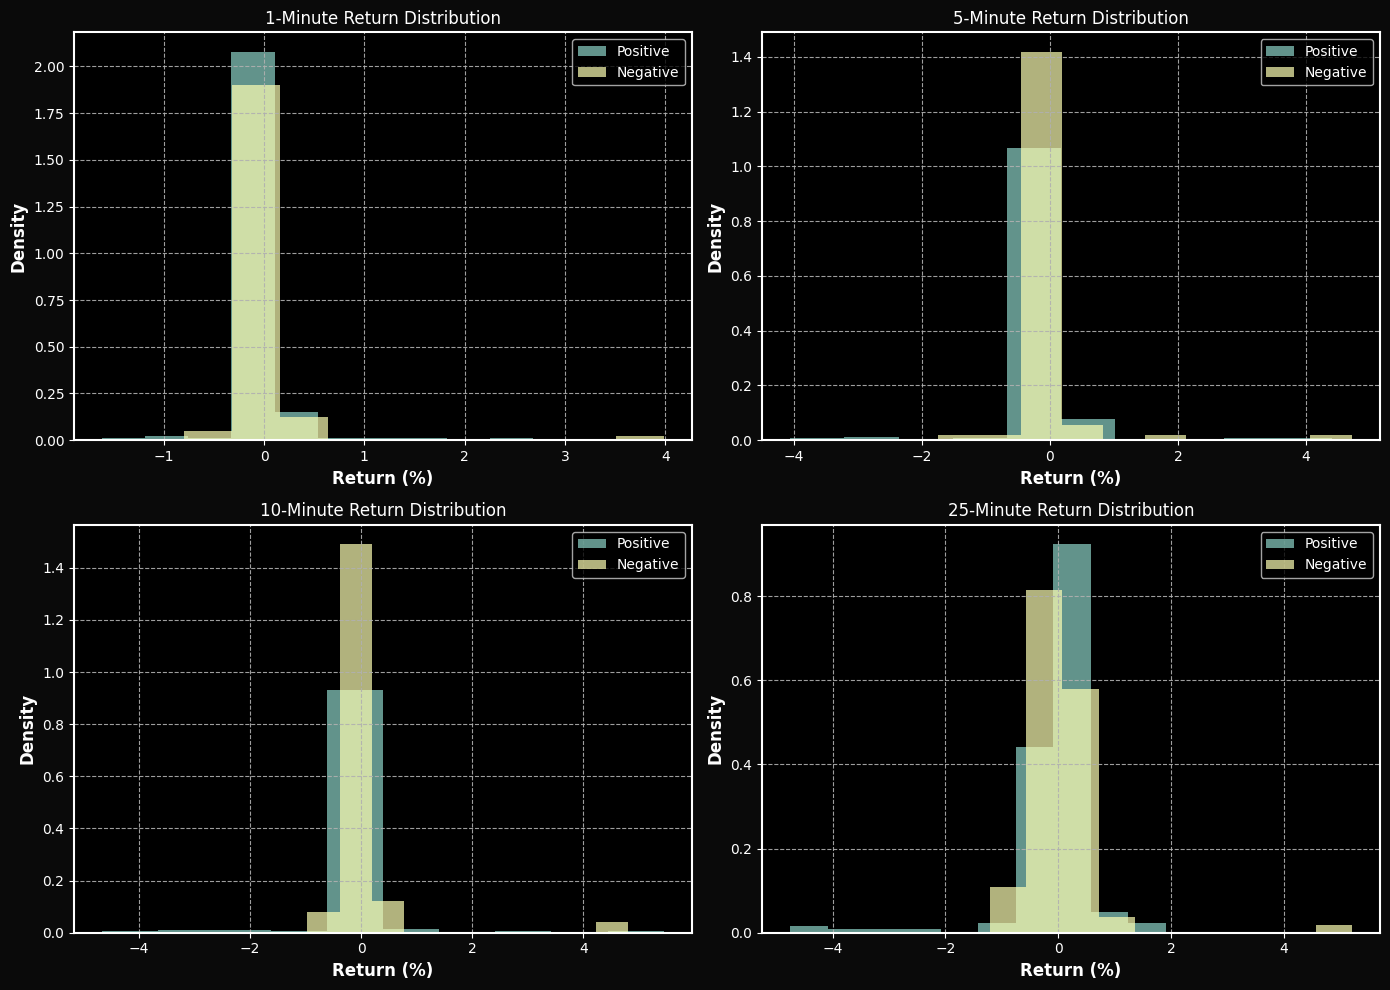

In [ ]:
# Apply return calculations directly to market_open_df
returns = []
for _, row in market_open_df.iterrows():
    changes = calculate_price_changes(row['stock_data'], row['created_at'])
    changes['sentiment'] = row['sentiment_llm']
    returns.append(changes)

# Convert to DataFrame
returns_df = pd.DataFrame(returns)


 # Create 2x2 subplot for intervals: 1, 5, 10, 30 minutes
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
intervals = [1, 5, 10, 25]
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for interval, pos in zip(intervals, positions):
    ax = axs[pos[0]][pos[1]]
    col = f'{interval} min (%)'

    # Drop NA and get returns by sentiment
    pos_returns = returns_df[returns_df['sentiment'] == 'positive'][col].dropna()
    neg_returns = returns_df[returns_df['sentiment'] == 'negative'][col].dropna()

    # Plot histograms
    ax.hist(pos_returns, bins=10, alpha=0.7, label='Positive', density=True)
    ax.hist(neg_returns, bins=10, alpha=0.7, label='Negative', density=True)

    ax.set_title(f'{interval}-Minute Return Distribution')
    ax.set_xlabel('Return (%)')
    ax.set_ylabel('Density')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Create a summary DataFrame for percentiles by sentiment and interval
summary = []

for interval in [1, 5, 10, 25]:
    col = f'{interval} min (%)'

    for sentiment in ['positive', 'negative']:
        returns = returns_df[returns_df['sentiment'] == sentiment][col].dropna()
        if not returns.empty:
            p25, p50, p75 = np.percentile(returns, [25, 50, 75])
            summary.append({
                'Interval (min)': interval,
                'Sentiment': sentiment,
                '25%': p25,
                '50% (Median)': p50,
                '75%': p75
            })

summary_df = pd.DataFrame(summary)
summary_df

,Interval (min),Sentiment,25%,50% (Median),75%
0,1,positive,-0.039586,0.005439,0.035477
1,1,negative,-0.060578,-0.003727,0.039071
2,5,positive,-0.092180,-0.003316,0.056237
3,5,negative,-0.068792,-0.026079,0.051117
4,10,positive,-0.125681,0.003670,0.085788
5,10,negative,-0.143807,-0.014118,0.066867
6,25,positive,-0.132105,0.010574,0.157753
7,25,negative,-0.136752,0.009146,0.186564


### Volume Analysis

In [ ]:
enriched_posts = df_combined_enriched.query('data_pulled == True').reset_index(drop=True).copy()
def plot_volume_change(enriched_posts):
  # Load NYSE calendar
  nyse = mcal.get_calendar('NYSE')

  # Add columns to track average volumes and volume ratio
  for minutes in [1, 5, 25]:
      enriched_posts[f'avg_volume_-{minutes}m'] = np.nan
      enriched_posts[f'avg_volume_+{minutes}m'] = np.nan
      enriched_posts[f'volume_pct_change_{minutes}m'] = np.nan

  # Function to check if interval is fully within market hours
  def is_interval_during_market(start_time, end_time):
      schedule = nyse.schedule(start_time.date(), end_time.date())
      if schedule.empty:
          return False
      market_open = schedule.iloc[0]['market_open'].tz_convert('UTC')
      market_close = schedule.iloc[0]['market_close'].tz_convert('UTC')
      return (start_time >= market_open) and (end_time <= market_close)

  # Main loop

  for idx, row in tqdm(enriched_posts.iterrows(), total=len(enriched_posts)):
      post_time = row["created_at"]
      minute_data = row.get("stock_data")

      if isinstance(minute_data, pd.DataFrame) and not minute_data.empty:
          minute_data = minute_data.sort_index()

          for minutes in [1, 5, 25]:
              try:
                  # Define time intervals
                  start_before = post_time - timedelta(minutes=minutes)
                  end_before = post_time
                  start_after = post_time
                  end_after = post_time + timedelta(minutes=minutes)

                  # Ensure both intervals are during market hours
                  if not is_interval_during_market(start_before, end_before) or not is_interval_during_market(start_after, end_after):
                      continue

                  # Get volume data
                  vol_before = minute_data.loc[start_before:end_before]['volume']
                  vol_after = minute_data.loc[start_after:end_after]['volume']

                  if not vol_before.empty and not vol_after.empty:
                      avg_before = vol_before.mean()
                      avg_after = vol_after.mean()
                      pct_change = ((avg_after - avg_before) / avg_before) * 100

                      enriched_posts.at[idx, f'avg_volume_-{minutes}m'] = avg_before
                      enriched_posts.at[idx, f'avg_volume_+{minutes}m'] = avg_after
                      enriched_posts.at[idx, f'volume_pct_change_{minutes}m'] = pct_change
              except Exception as e:
                  print(f"⚠️ Error at row {idx}, window {minutes}m: {e}")
                  continue

  # Filter valid rows
  eligible_volume = enriched_posts[enriched_posts['volume_pct_change_1m'].notna()].copy()

  plt.figure(figsize=(18, 5))
  for i, minutes in enumerate([1, 5, 25]):
      col = f'volume_pct_change_{minutes}m'
      data = eligible_volume[col].dropna()
      median_val = data.median()

      plt.subplot(1, 3, i + 1)
      plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
      plt.axvline(median_val, color='red', linestyle='--', label=f'Median ({median_val:.2f}%)')
      plt.title(f'Volume % Change (+{minutes} min)')
      plt.xlabel('% Change in Avg Volume')
      plt.ylabel('Frequency')
      plt.legend()

  plt.tight_layout()
  plt.show()
  return eligible_volume

100%|██████████| 305/305 [01:28<00:00,  3.45it/s]


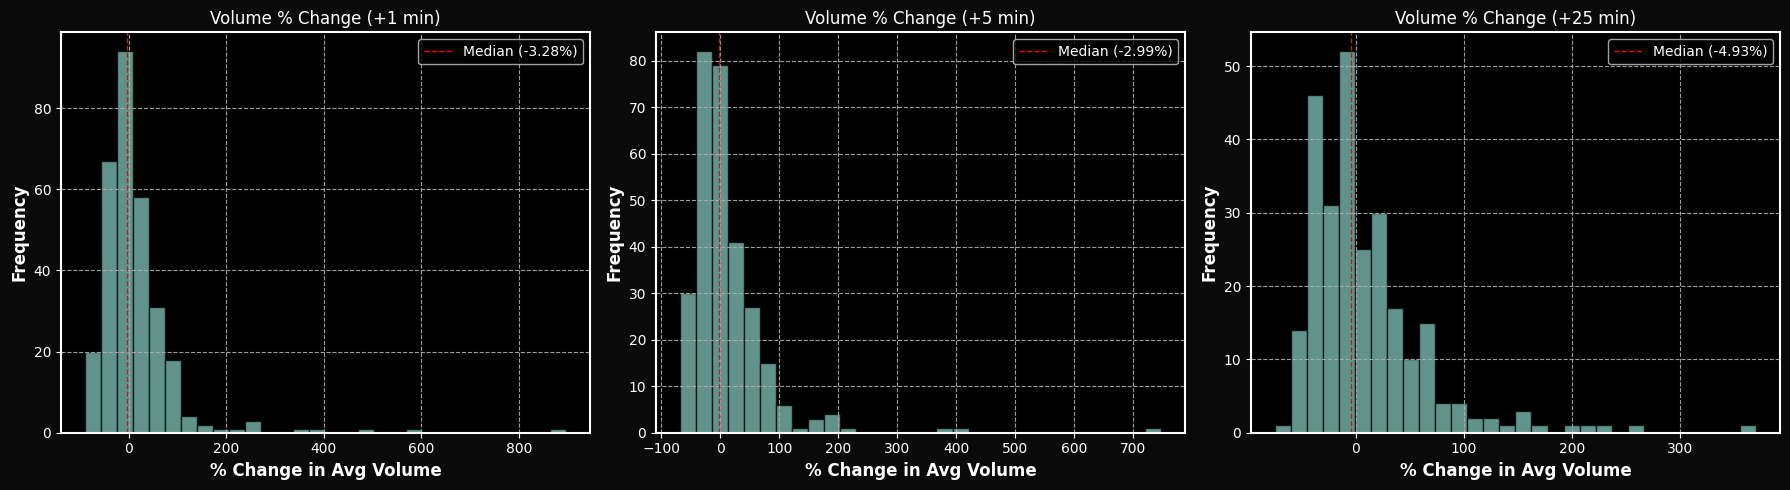

In [ ]:
eligible_volume = plot_volume_change(market_open_df)

In [ ]:
eligible_volume.head()

,created_at,text,main_topics,sentiment_llm,confidence,data_pulled,stock_data,avg_volume_-1m,avg_volume_+1m,volume_pct_change_1m,avg_volume_-5m,avg_volume_+5m,volume_pct_change_5m,avg_volume_-25m,avg_volume_+25m,volume_pct_change_25m,avg_volume_-30m,avg_volume_+30m,volume_pct_change_30m
30,2025-05-23 19:37:11.074000+00:00,https://rumble.com/v6truv3-president-trump-sig...,"[executive orders, US economic policy, governm...",neutral,0.70,True,open high ...,133360.0,185403.0,39.024445,162438.8,146861.6,-9.589581,NaN,NaN,NaN,NaN,NaN,NaN
32,2025-05-23 19:25:17.732000+00:00,"I am proud to announce that, after much consid...","[US Steel and Nippon Steel partnership, Job cr...",positive,0.95,True,open high ...,135915.0,246141.0,81.099216,174886.2,187082.6,6.973906,144994.92,182127.28,25.609421,135183.700000,253819.066667,87.758633
42,2025-05-22 18:28:52.090000+00:00,Another very big and successful week of WINS f...,"[voter registration trends, political party do...",positive,0.95,True,open hig...,105608.0,64423.0,-38.997993,121179.0,114389.8,-5.602621,139672.72,114568.80,-17.973388,135076.333333,115543.433333,-14.460638
43,2025-05-22 17:33:35.465000+00:00,"A Federal Judge in Boston, who knew absolutely...",[Judicial decisions impacting immigration enfo...,negative,0.93,True,open high ...,94259.0,141399.0,50.011140,100726.6,101498.6,0.766431,126792.72,109388.84,-13.726245,116611.100000,109839.766667,-5.806766
54,2025-05-20 19:55:51.820000+00:00,We must maintain our status as the Worldwide L...,"[Spectrum auction policy, Telecommunications i...",positive,0.95,True,open high ...,624738.0,344298.0,-44.889218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
